<a href="https://colab.research.google.com/github/talhaanwarch/skin_cancer_detection_phone_camera/blob/master/Scenario_VI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Scenario II:** Training on ISIC 2019 and tested on PAD dataset (Only images)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!cp /content/drive/My\ Drive/isic_weights/isicall_eff3_weights.hdf5 /content/

In [ ]:
%%capture
!pip install efficientnet
!pip install catboost

In [ ]:
#download the dataset
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/zr7vgbcyr2-1.zip

--2020-08-26 00:34:07--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/zr7vgbcyr2-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.49.91
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.49.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3593344681 (3.3G) [application/octet-stream]
Saving to: ‘zr7vgbcyr2-1.zip’

zr7vgbcyr2-1.zip    100%[===================>]   3.35G  9.54MB/s    in 6m 10s  

2020-08-26 00:40:18 (9.25 MB/s) - ‘zr7vgbcyr2-1.zip’ saved [3593344681/3593344681]



In [ ]:
#unzip the dataset
%%capture
!unzip zr7vgbcyr2-1.zip

In [ ]:
#create a new folder named as data
!mkdir data

In [ ]:
#unzip all subfolder
%%capture
!unzip /content/images/imgs_part_1.zip
!unzip /content/images/imgs_part_2.zip
!unzip /content/images/imgs_part_3.zip

In [ ]:
#move all pictures from subfolder to main folder data
!mv  /content/imgs_part_1/* /content/data
!mv  /content/imgs_part_2/* /content/data
!mv  /content/imgs_part_3/* /content/data

In [ ]:
#remove the folder that contain subfolders
!rm -r /content/images

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold,StratifiedKFold
import gc

from sklearn.metrics import classification_report,accuracy_score,f1_score,roc_auc_score,precision_score,recall_score
#read annotation file
df=pd.read_csv('/content/metadata.csv')
df.head()

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,has_sewage_system,fitspatrick,region,diameter_1,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
0,PAT_1516,1765,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ARM,NaN,NaN,NEV,False,False,False,False,False,False,PAT_1516_1765_530.png,False
1,PAT_46,881,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,True,True,True,3.0,NECK,6.0,5.0,BCC,True,True,False,True,True,True,PAT_46_881_939.png,True
2,PAT_1545,1867,NaN,NaN,NaN,NaN,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FACE,NaN,NaN,ACK,True,False,False,False,False,False,PAT_1545_1867_547.png,False
3,PAT_1989,4061,NaN,NaN,NaN,NaN,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HAND,NaN,NaN,ACK,True,False,False,False,False,False,PAT_1989_4061_934.png,False
4,PAT_684,1302,False,True,POMERANIA,POMERANIA,79,False,MALE,True,False,False,False,1.0,FOREARM,5.0,5.0,BCC,True,True,False,False,True,True,PAT_684_1302_588.png,True


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2298 entries, 0 to 2297
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient_id           2298 non-null   object 
 1   lesion_id            2298 non-null   int64  
 2   smoke                1494 non-null   object 
 3   drink                1494 non-null   object 
 4   background_father    1480 non-null   object 
 5   background_mother    1476 non-null   object 
 6   age                  2298 non-null   int64  
 7   pesticide            1494 non-null   object 
 8   gender               1494 non-null   object 
 9   skin_cancer_history  1494 non-null   object 
 10  cancer_history       1494 non-null   object 
 11  has_piped_water      1494 non-null   object 
 12  has_sewage_system    1494 non-null   object 
 13  fitspatrick          1494 non-null   float64
 14  region               2298 non-null   object 
 15  diameter_1           1494 non-null   f

In [ ]:
df['smoke']=df['smoke'].fillna('unknown').astype('str')
df['drink']=df['drink'].fillna('unknown').astype('str')
df['pesticide']=df['pesticide'].fillna('unknown').astype('str')
df['gender']=df['gender'].fillna('unknown').astype('str')
df['skin_cancer_history']=df['skin_cancer_history'].fillna('unknown').astype('str')
df['cancer_history']=df['cancer_history'].fillna('unknown').astype('str')
df['has_piped_water']=df['has_piped_water'].fillna('unknown').astype('str')
df['has_sewage_system']=df['has_sewage_system'].fillna('unknown').astype('str')

df['fitspatrick']=df['fitspatrick'].fillna('unknown').astype('str')
df['has_sewage_system']=df['has_sewage_system'].fillna('unknown').astype('str')

In [ ]:
df['diameter_1'].fillna(df['diameter_1'].mean(),inplace=True)
df['diameter_2'].fillna(df['diameter_2'].mean(),inplace=True)

In [ ]:
df.columns

Index(['patient_id', 'lesion_id', 'smoke', 'drink', 'background_father',
       'background_mother', 'age', 'pesticide', 'gender',
       'skin_cancer_history', 'cancer_history', 'has_piped_water',
       'has_sewage_system', 'fitspatrick', 'region', 'diameter_1',
       'diameter_2', 'diagnostic', 'itch', 'grew', 'hurt', 'changed', 'bleed',
       'elevation', 'img_id', 'biopsed'],
      dtype='object')

In [ ]:
clinical_features=df[['smoke', 'drink', 'age', 'pesticide', 'gender',
       'skin_cancer_history', 'cancer_history', 'has_piped_water',
       'has_sewage_system', 'fitspatrick', 'region', 'diameter_1',
       'diameter_2',  'itch', 'grew', 'hurt', 'changed', 'bleed',
       'elevation', 'img_id', 'biopsed']]
clinical_lables=df['diagnostic']

In [ ]:
clinical_features.head()

,smoke,drink,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,has_sewage_system,fitspatrick,region,diameter_1,diameter_2,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
0,unknown,unknown,8,unknown,unknown,unknown,unknown,unknown,unknown,unknown,ARM,11.897055,8.852209,False,False,False,False,False,False,PAT_1516_1765_530.png,False
1,False,False,55,False,FEMALE,True,True,True,True,3.0,NECK,6.000000,5.000000,True,True,False,True,True,True,PAT_46_881_939.png,True
2,unknown,unknown,77,unknown,unknown,unknown,unknown,unknown,unknown,unknown,FACE,11.897055,8.852209,True,False,False,False,False,False,PAT_1545_1867_547.png,False
3,unknown,unknown,75,unknown,unknown,unknown,unknown,unknown,unknown,unknown,HAND,11.897055,8.852209,True,False,False,False,False,False,PAT_1989_4061_934.png,False
4,False,True,79,False,MALE,True,False,False,False,1.0,FOREARM,5.000000,5.000000,True,True,False,False,True,True,PAT_684_1302_588.png,True


In [ ]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
encLE=LabelEncoder()
encOHE=OneHotEncoder(sparse=False)
clinical_features=encOHE.fit_transform(clinical_features)
clinical_lables=encOHE.fit_transform(clinical_lables.values.reshape(-1,1))
clinical_features.shape,clinical_lables.shape

((2298, 2529), (2298, 6))

In [ ]:
# from sklearn.model_selection import train_test_split
# cX_train,cX_test,cY_train,cY_test=train_test_split(clinical_features,clinical_lables,test_size=0.3)

In [ ]:
# from catboost import CatBoostClassifier
# cat_model = CatBoostClassifier()
# cat_model.fit(cX_train,cY_train,verbose=False)

In [ ]:
# y_pred=cat_model.predict(cX_test)
# print(f1_score(cY_test,y_pred,average='macro'))

In [ ]:
#create a dataframe with image name and encoded labels
labels=pd.get_dummies(df['diagnostic'])
df=pd.concat([df,labels],axis=1)
df.head()
#MEL	NV	BCC	AK	BKL		SCC

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,has_sewage_system,fitspatrick,region,diameter_1,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed,ACK,BCC,MEL,NEV,SCC,SEK
0,PAT_1516,1765,unknown,unknown,NaN,NaN,8,unknown,unknown,unknown,unknown,unknown,unknown,unknown,ARM,11.897055,8.852209,NEV,False,False,False,False,False,False,PAT_1516_1765_530.png,False,0,0,0,1,0,0
1,PAT_46,881,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,True,True,True,3.0,NECK,6.000000,5.000000,BCC,True,True,False,True,True,True,PAT_46_881_939.png,True,0,1,0,0,0,0
2,PAT_1545,1867,unknown,unknown,NaN,NaN,77,unknown,unknown,unknown,unknown,unknown,unknown,unknown,FACE,11.897055,8.852209,ACK,True,False,False,False,False,False,PAT_1545_1867_547.png,False,1,0,0,0,0,0
3,PAT_1989,4061,unknown,unknown,NaN,NaN,75,unknown,unknown,unknown,unknown,unknown,unknown,unknown,HAND,11.897055,8.852209,ACK,True,False,False,False,False,False,PAT_1989_4061_934.png,False,1,0,0,0,0,0
4,PAT_684,1302,False,True,POMERANIA,POMERANIA,79,False,MALE,True,False,False,False,1.0,FOREARM,5.000000,5.000000,BCC,True,True,False,False,True,True,PAT_684_1302_588.png,True,0,1,0,0,0,0


In [ ]:
#shuffle the dataframe
# df=df.sample(frac=1)
# df.head()

In [ ]:
#labels columns in dataframe
col=list(df.columns)[-6::]
col

['ACK', 'BCC', 'MEL', 'NEV', 'SCC', 'SEK']

In [ ]:
# data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_gen= ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=360,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=.1,
    rescale=1/255,
    fill_mode='nearest')

In [ ]:
# model hyperparameters
img_shape=300
batch_size=20
n_epochs=20

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D,Dropout,Dense,Input,concatenate,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential,Model

In [ ]:
def dense_model():
  inp=Input(shape=(2529,))
  y=Dense(1024,activation="relu")(inp)
  y=Dense(256,activation="relu")(y)
  y=Dense(128,activation="relu")(y)
  y=Dense(64,activation="relu")(y)
  out=Dense(6,activation="softmax")(y)
  densemodel=Model(inputs=inp, outputs=out )
  densemodel.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return densemodel



In [ ]:
# densemodel=dense_model()
# #densemodel.summary()
# densemodel.fit(x=clinical_features,y=clinical_lables,epochs=5,validation_split=0.2)

In [ ]:
#first create the pretrained model and load weights


In [ ]:
def basemodel():
  import efficientnet.tfkeras as efn
  pre_trained_model =efn.EfficientNetB3(weights =None, include_top=False, input_shape = (img_shape,img_shape,3))
  x = pre_trained_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation="relu")(x)
  x = Dropout(0.3)(x)
  x = Dense(64, activation="relu")(x)
  predictions = Dense(8, activation="softmax")(x) #pretrained model has 7 classes
  pre_trained_model = Model(inputs=pre_trained_model.input, outputs=predictions)
  pre_trained_model.load_weights('/content/isicall_eff3_weights.hdf5') #load pretrained weights to to model
  #now remove all added layers in pretrained layers add new leayer and create base model
  #here we can test how many layers we want to remove
  eff_model = Model(pre_trained_model.input, pre_trained_model.layers[-7].output)
  #now add our new layers
  x = eff_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.3)(x)
  x = Dense(128,name='dense1', activation="relu")(x)
  x = Dropout(0.3)(x)
  x = Dense(64,name='dense2', activation="relu")(x)


  inp=Input(shape=(2529,))
  y=Dense(1024,activation="relu")(inp)
  y=Dense(256,activation="relu")(y)
  y=Dense(128,activation="relu")(y)
  y=Dropout(0.3)(y)
  y=Dense(64,activation="relu")(y)

  z=concatenate([x,y])
  z=Dropout(0.3)(z)
  z=Dense(32,activation='relu')(z)
  z=Dense(16,activation='relu')(z)

  predictions  = Dense(len(col),name='output', activation="softmax")(z) #base model has six layers
  model = Model(inputs=[eff_model.input,inp], outputs=predictions )
  #compile the base model
  model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:

def dual_datagen(df,clinical_features,batch_size=20):
    eff_generator=data_gen.flow_from_dataframe(df,directory='/content/data',
                                               target_size=(img_shape,img_shape),
                                               x_col='img_id',
                                               y_col=col,
                                               class_mode='raw',
                                               shuffle=False,
                                               batch_size=batch_size)
    number_of_batches = len(clinical_features)/batch_size
    counter =0
    while True:
        x_1 = eff_generator.next()
        x_2 = np.array(clinical_features[batch_size*counter:batch_size*(counter+1)]).astype('float32')
        counter += 1

        yield [x_1[0], x_2], x_1[1]
        if counter >= number_of_batches:
          counter = 0

In [ ]:
# train_gen =dual_datagen(df,clinical_features)
# model.fit(train_gen,epochs=2,steps_per_epoch=len(df)/20)

In [ ]:


classification_reports=[]
kf = KFold(n_splits=5,shuffle=False)
history=[]
accuracy=[]
f1_scores=[]
auc=[]
y_pred=[]
precision=[]
recall=[]
fold=0
for train_index, test_index in kf.split(df):
  train_img=df.iloc[train_index,:]
  val_img=df.iloc[test_index,:]

  train_feat=clinical_features[train_index,:]
  val_feat=clinical_features[test_index,:]

  print('-----------fold {}--------------'.format(fold))
  train_gen =dual_datagen(train_img,train_feat)

  #load base model
  model=basemodel()
  val_gen =dual_datagen(val_img,val_feat)
  #train model
  results = model.fit(train_gen,epochs=20,verbose=1,
                              steps_per_epoch=len(train_img)/batch_size,
                              validation_data=val_gen,
                             validation_steps=len(val_img)/batch_size,
                              callbacks=[ReduceLROnPlateau(monitor='val_loss',verbose=1, factor=0.5,patience=5, min_lr=0.000001),
                                         #ModelCheckpoint('model_{}.hdf5'.format(fold), save_best_only=True, monitor='val_loss', mode='min')
                                         ])
  

  val_gen =dual_datagen(val_img,val_feat)
  y_true=val_img.iloc[:,-6::]
  y_pred=model.predict(val_gen,steps=len(val_img)/batch_size,verbose=0)
  print(accuracy_score(np.round(y_pred,0),y_true))
  print(f1_score(np.round(y_pred,0),y_true,average='macro'))

  precision.append(precision_score(y_true,np.round(y_pred,0),average='macro'))
  recall.append(recall_score(y_true,np.round(y_pred,0),average='macro'))
  accuracy.append(accuracy_score(y_true,np.round(y_pred,0)))
  auc.append(roc_auc_score(y_true,np.round(y_pred,0)))
  f1_scores.append(f1_score(y_true,np.round(y_pred,0),average='macro'))
  history.append(results)
  fold+=1

  del model
  K.clear_session()
  gc.collect()

-----------fold 0--------------
Found 1838 validated image filenames.
Epoch 1/20
92/91 [==============================] - 168s 2s/step - loss: 1.0401 - accuracy: 0.6328 - val_loss: 0.7548 - val_accuracy: 0.7435
Epoch 2/20
92/91 [==============================] - 165s 2s/step - loss: 0.6756 - accuracy: 0.7612 - val_loss: 0.6359 - val_accuracy: 0.7543
Epoch 3/20
92/91 [==============================] - 165s 2s/step - loss: 0.5095 - accuracy: 0.8009 - val_loss: 0.8202 - val_accuracy: 0.7196
Epoch 4/20
92/91 [==============================] - 166s 2s/step - loss: 0.4083 - accuracy: 0.8466 - val_loss: 0.6800 - val_accuracy: 0.7826
Epoch 5/20
92/91 [==============================] - 167s 2s/step - loss: 0.2986 - accuracy: 0.8906 - val_loss: 0.7681 - val_accuracy: 0.7870
Epoch 6/20
92/91 [==============================] - 168s 2s/step - loss: 0.2212 - accuracy: 0.9260 - val_loss: 0.8932 - val_accuracy: 0.7935
Epoch 7/20
92/91 [==============================] - ETA: 0s - loss: 0.1861 - accurac

In [ ]:
np.mean(precision)

0.7467650449638831

In [ ]:
np.mean(recall)

0.7681606746762559

In [ ]:
#average accuracy across all folds
np.mean(accuracy)

0.8093833475419153

In [ ]:
#average f1_scores across all folds
np.mean(f1_scores)

0.7499370019223646

In [ ]:
#average auc_scores across all folds
np.mean(auc)

0.8644411046158771

In [ ]:
history[0].history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [ ]:
def plot_accuracy(hist,acc='val_accuracy'):
    for i in range(5):
      plt.plot(hist[i].history[acc],linestyle='-.',linewidth=1.5)
     
    mean=np.mean([[j for j in x.history[acc]] for x in hist],axis=0)
    std=np.std([[j for j in x.history[acc]] for x in hist],axis=0)
    plt.plot(mean,linewidth=2,color='black')
    if acc=='val_accuracy':
      plt.title('Model Validation Accuracy')
    else:
      plt.title('Model Training Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Fold1','Fold2','Fold3','Fold4','Fold5','Average Val Accuracy' ], loc='best')
    plt.show()

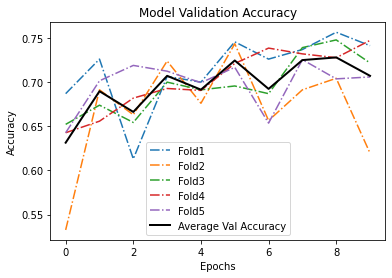

In [ ]:
plot_accuracy(history)

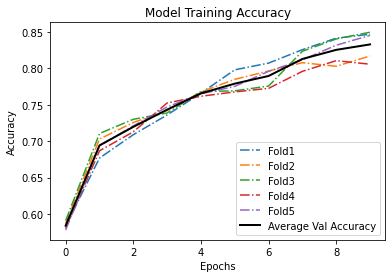

In [ ]:
plot_accuracy(history,acc='accuracy')